# Problème 2: Collecte de données Yahoo Finance (2012-2023)



In [1]:
import yfinance as yf
import pandas as pd
import os

def fetch_yahoo_finance(tickers, start='2012-01-03', end='2023-02-01', out_path='yahoo_data.csv'):
    """Télécharge les données Yahoo Finance pour une liste de tickers jusqu'au 3 janvier 2023"""
    
    print(f"Téléchargement de {len(tickers)} titres...")
    all_data = []
    
    for i, ticker in enumerate(tickers):
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(start=start, end=end)
            
            if len(data) > 0:
                # Filtrer jusqu'au 3 janvier 2023 inclus
                data = data[data.index <= '2023-01-03']
                
                data = data[['Close']].copy()
                data.reset_index(inplace=True)
                data['ticker'] = ticker
                data.columns = ['date', 'adj_close', 'ticker']
                #calcul des rendements
                data['returns'] = data['adj_close'].pct_change()
                data = data[['date', 'ticker', 'adj_close', 'returns']]
                all_data.append(data)
                
        except Exception as e:
            print(f"Erreur pour {ticker}: {e}")
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
        df.to_csv(out_path, index=False)
        print(f"Données sauvegardées: {len(df):,} observations")
        return df
    else:
        print("Aucune donnée récupérée")
        return pd.DataFrame()

In [10]:
# Liste complète des 10 titres requis (mêmes que CRSP mais avec tickers Yahoo)
tickers_yahoo = [
    # INDICE DE MARCHÉ
    'SPY',              # SPDR S&P 500 ETF Trust
    
    # SECTEUR FINANCIER
    'EFX',              # Equifax Inc. 
    'JPM',              # JPMorgan Chase & Co.
    'GS',              # Goldman Sachs Group Inc.
    
    # SECTEUR TECHNOLOGIQUE
    'EA',               # Electronic Arts Inc.
    'JBL',              # Jabil Inc.
    'GOOGL',            # Alphabet Inc. (Class A)
    
    # SECTEUR ÉNERGÉTIQUE
    'EOG',              # EOG Resources Inc.
    'JKS',              # JinkoSolar Holding Co.
    'GTE',              # Gran Tierra Energy Inc.
]

# Mapping pour organisation par secteur
secteurs_mapping = {
    'SPY': 'Indice de marché',
    'EFX': 'Secteur financier', 'JPM': 'Secteur financier', 'GS': 'Secteur financier',
    'EA': 'Secteur technologique', 'JBL': 'Secteur technologique', 'GOOGL': 'Secteur technologique',
    'EOG': 'Secteur énergétique', 'JKS': 'Secteur énergétique', 'GTE': 'Secteur énergétique'
}

In [11]:
# TÉLÉCHARGEMENT ET ORGANISATION DES DONNÉES

# Vérifier si on a tous les 10 titres requis ET la bonne période
if os.path.exists('donnees_yahoo_probleme2.csv'):
    df_temp = pd.read_csv('donnees_yahoo_probleme2.csv')
    df_temp['date'] = pd.to_datetime(df_temp['date'], utc=True)
    tickers_existants = df_temp['ticker'].unique()
    date_max = df_temp['date'].max().date()
    
    # Vérifier 10 titres ET période jusqu'au 3 janvier 2023
    if (len(tickers_existants) == 10 and 
        all(ticker in tickers_existants for ticker in tickers_yahoo) and
        date_max >= pd.to_datetime('2023-01-03').date()):
        df = df_temp.copy()
    else:
        df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')
else:
    df = fetch_yahoo_finance(tickers_yahoo, out_path='donnees_yahoo_probleme2.csv')

# Ajouter la colonne secteur et organiser les données
df['secteur'] = df['ticker'].map(secteurs_mapping)
df = df[['date', 'ticker', 'secteur', 'adj_close', 'returns']]

# Créer les fichiers individuels
os.makedirs('donnees_individuelles_yahoo', exist_ok=True)
for ticker in tickers_yahoo:
    fichier = f'donnees_individuelles_yahoo/{ticker}.csv'
    data_ticker = df[df['ticker'] == ticker]
    data_ticker.to_csv(fichier, index=False)

# RÉSUMÉ DES DONNÉES
print(f"\nStructure: {df.shape[0]:,} observations, {df.shape[1]} colonnes")
print(f"Période: {df['date'].min().date()} à {df['date'].max().date()}")

print(f"\nObservations par titre:")
obs_par_titre = df.groupby(['ticker', 'secteur']).size().reset_index(name='observations')
for _, row in obs_par_titre.iterrows():
    print(f"  {row['ticker']} ({row['secteur']}): {row['observations']:,} obs")


Structure: 27,690 observations, 5 colonnes
Période: 2012-01-03 à 2023-01-03

Observations par titre:
  EA (Secteur technologique): 2,769 obs
  EFX (Secteur financier): 2,769 obs
  EOG (Secteur énergétique): 2,769 obs
  GOOGL (Secteur technologique): 2,769 obs
  GS (Secteur financier): 2,769 obs
  GTE (Secteur énergétique): 2,769 obs
  JBL (Secteur technologique): 2,769 obs
  JKS (Secteur énergétique): 2,769 obs
  JPM (Secteur financier): 2,769 obs
  SPY (Indice de marché): 2,769 obs


# Problème 2(a): Statistiques descriptives et graphiques des rendements



In [12]:
# Importer les librairies pour les graphiques et statistiques
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Configuration des graphiques
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Supprimer les valeurs manquantes pour les calculs
df_clean = df.dropna(subset=['returns'])

print("=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===\n")

# Calculer les statistiques descriptives par titre
stats_summary = []

for ticker in tickers_yahoo:
    data_ticker = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Ratio de Sharpe (annualisé, en supposant un taux sans risque de 0)
    sharpe_ratio = (data_ticker.mean() / data_ticker.std()) * np.sqrt(252) if data_ticker.std() != 0 else 0
    
    # Rendement cumulatif total sur la période
    cumulative_return = (1 + data_ticker).prod() - 1
    
    # Rendement annualisé (CAGR)
    num_years = len(data_ticker) / 252.0
    annualized_return = ((1 + cumulative_return) ** (1 / num_years)) - 1 if num_years > 0 else 0
    
    stats_dict = {
        'Ticker': ticker,
        'Secteur': secteur,
        'Observations': len(data_ticker),
        'Moyenne': data_ticker.mean(),
        'Écart-type': data_ticker.std(),
        'Minimum': data_ticker.min(),
        'Maximum': data_ticker.max(),
        'Rendement Cumulatif': cumulative_return,
        'Rendement Annuel': annualized_return,
        'Sharpe Ratio (Ann.)': sharpe_ratio,
        'Asymétrie': stats.skew(data_ticker),
        'Kurtosis': stats.kurtosis(data_ticker),
        'Jarque-Bera': stats.jarque_bera(data_ticker)[0],
        'JB p-value': stats.jarque_bera(data_ticker)[1]
    }
    stats_summary.append(stats_dict)
    
    # Afficher les statistiques pour chaque titre
    print(f"{ticker} ({secteur}):")
    print(f"  Observations: {stats_dict['Observations']:,}")
    print(f"  Moyenne: {stats_dict['Moyenne']:.6f} ({stats_dict['Moyenne']*252:.4f} annualisé)")
    print(f"  Écart-type: {stats_dict['Écart-type']:.6f} ({stats_dict['Écart-type']*np.sqrt(252):.4f} annualisé)")
    print(f"  Rendement Cumulatif Total: {stats_dict['Rendement Cumulatif']:.2%}")
    print(f"  Rendement Annuel (CAGR): {stats_dict['Rendement Annuel']:.2%}")
    print(f"  Ratio de Sharpe (Annualisé): {stats_dict['Sharpe Ratio (Ann.)']:.4f}")
    print(f"  Min/Max: {stats_dict['Minimum']:.6f} / {stats_dict['Maximum']:.6f}")
    print(f"  Asymétrie: {stats_dict['Asymétrie']:.4f}")
    print(f"  Kurtosis: {stats_dict['Kurtosis']:.4f}")
    print(f"  Jarque-Bera: {stats_dict['Jarque-Bera']:.2f} (p-value: {stats_dict['JB p-value']:.4f})")
    print()

# Créer un DataFrame des statistiques pour comparaison
stats_df = pd.DataFrame(stats_summary)
print("=== TABLEAU COMPARATIF DES STATISTIQUES ===")
# Réorganiser les colonnes pour une meilleure lisibilité
column_order = [
    'Ticker', 'Secteur', 'Observations', 'Moyenne', 'Écart-type',
    'Rendement Cumulatif', 'Rendement Annuel', 'Sharpe Ratio (Ann.)', 'Minimum', 'Maximum',
    'Asymétrie', 'Kurtosis', 'Jarque-Bera', 'JB p-value'
]
stats_df = stats_df[column_order]
print(stats_df.round(4).to_string(index=False))

=== STATISTIQUES DESCRIPTIVES DES RENDEMENTS ===

SPY (Indice de marché):
  Observations: 2,768
  Moyenne: 0.000528 (0.1331 annualisé)
  Écart-type: 0.010715 (0.1701 annualisé)
  Rendement Cumulatif Total: 267.60%
  Rendement Annuel (CAGR): 12.58%
  Ratio de Sharpe (Annualisé): 0.7823
  Min/Max: -0.109424 / 0.090603
  Asymétrie: -0.5569
  Kurtosis: 13.4799
  Jarque-Bera: 21100.03 (p-value: 0.0000)

EFX (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000778 (0.1961 annualisé)
  Écart-type: 0.016837 (0.2673 annualisé)
  Rendement Cumulatif Total: 480.59%
  Rendement Annuel (CAGR): 17.37%
  Ratio de Sharpe (Annualisé): 0.7335
  Min/Max: -0.147798 / 0.149406
  Asymétrie: -0.2903
  Kurtosis: 12.4243
  Jarque-Bera: 17842.00 (p-value: 0.0000)

JPM (Secteur financier):
  Observations: 2,768
  Moyenne: 0.000743 (0.1872 annualisé)
  Écart-type: 0.016969 (0.2694 annualisé)
  Rendement Cumulatif Total: 425.00%
  Rendement Annuel (CAGR): 16.30%
  Ratio de Sharpe (Annualisé): 0.6950
  Min/Ma


=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===



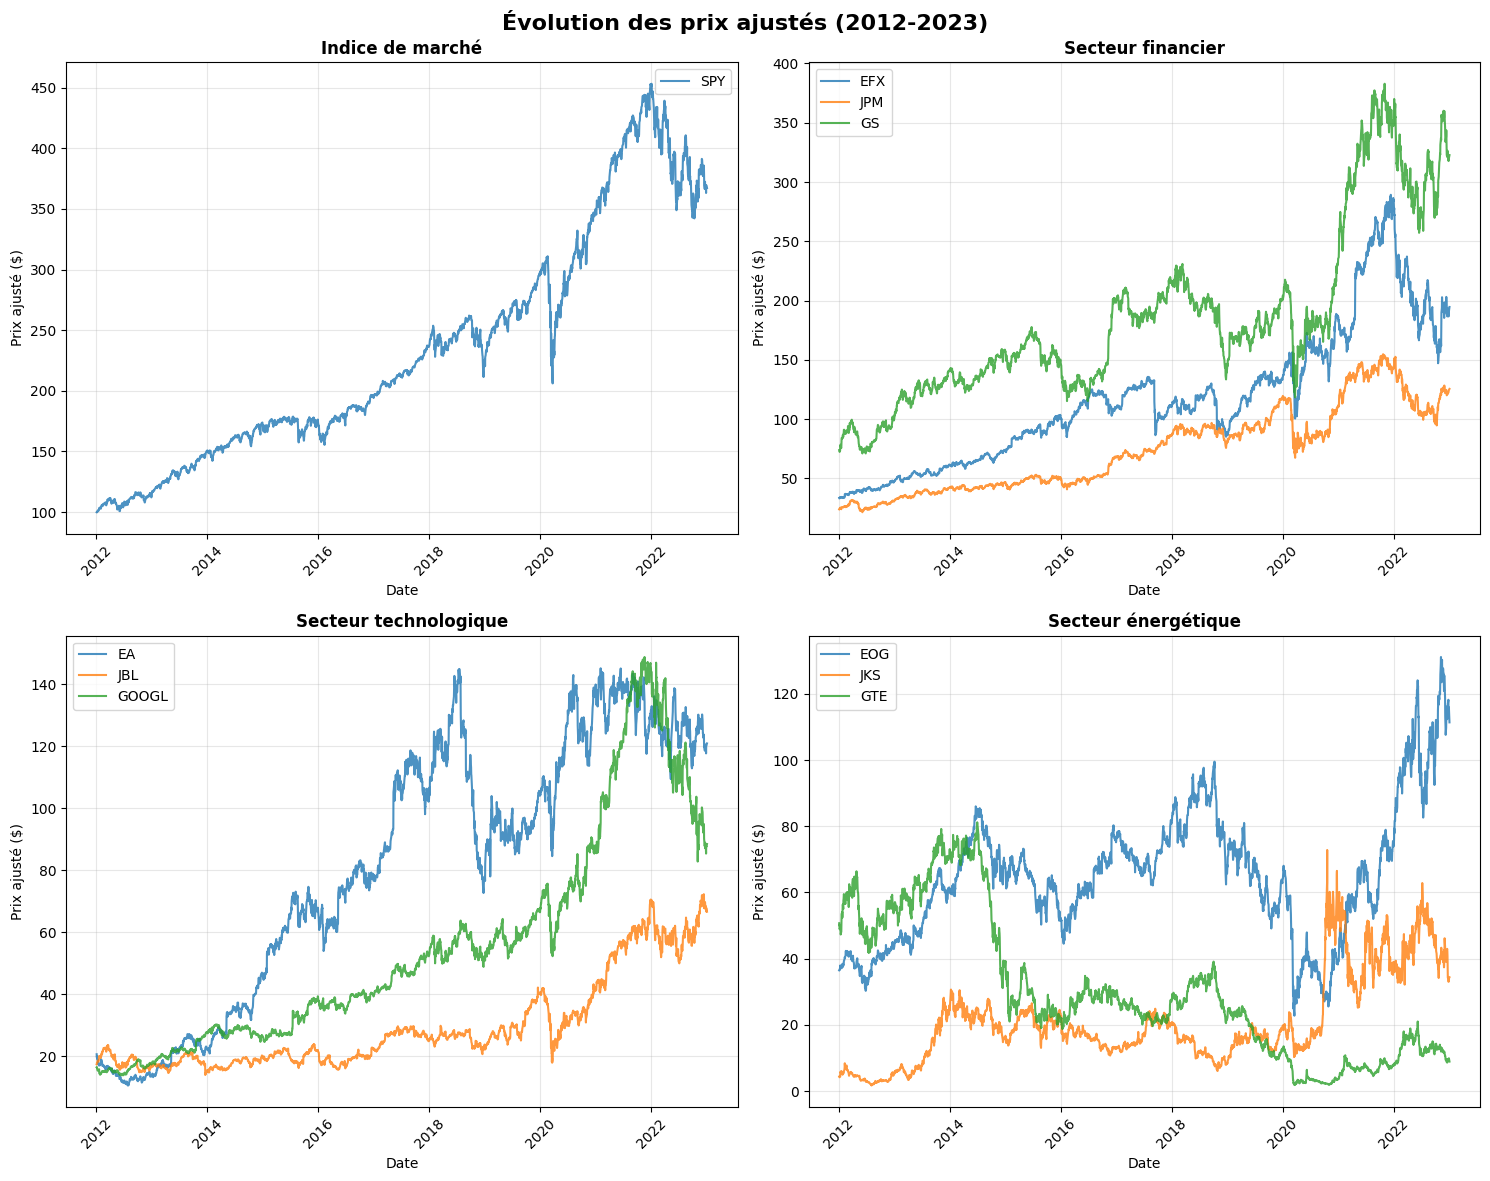

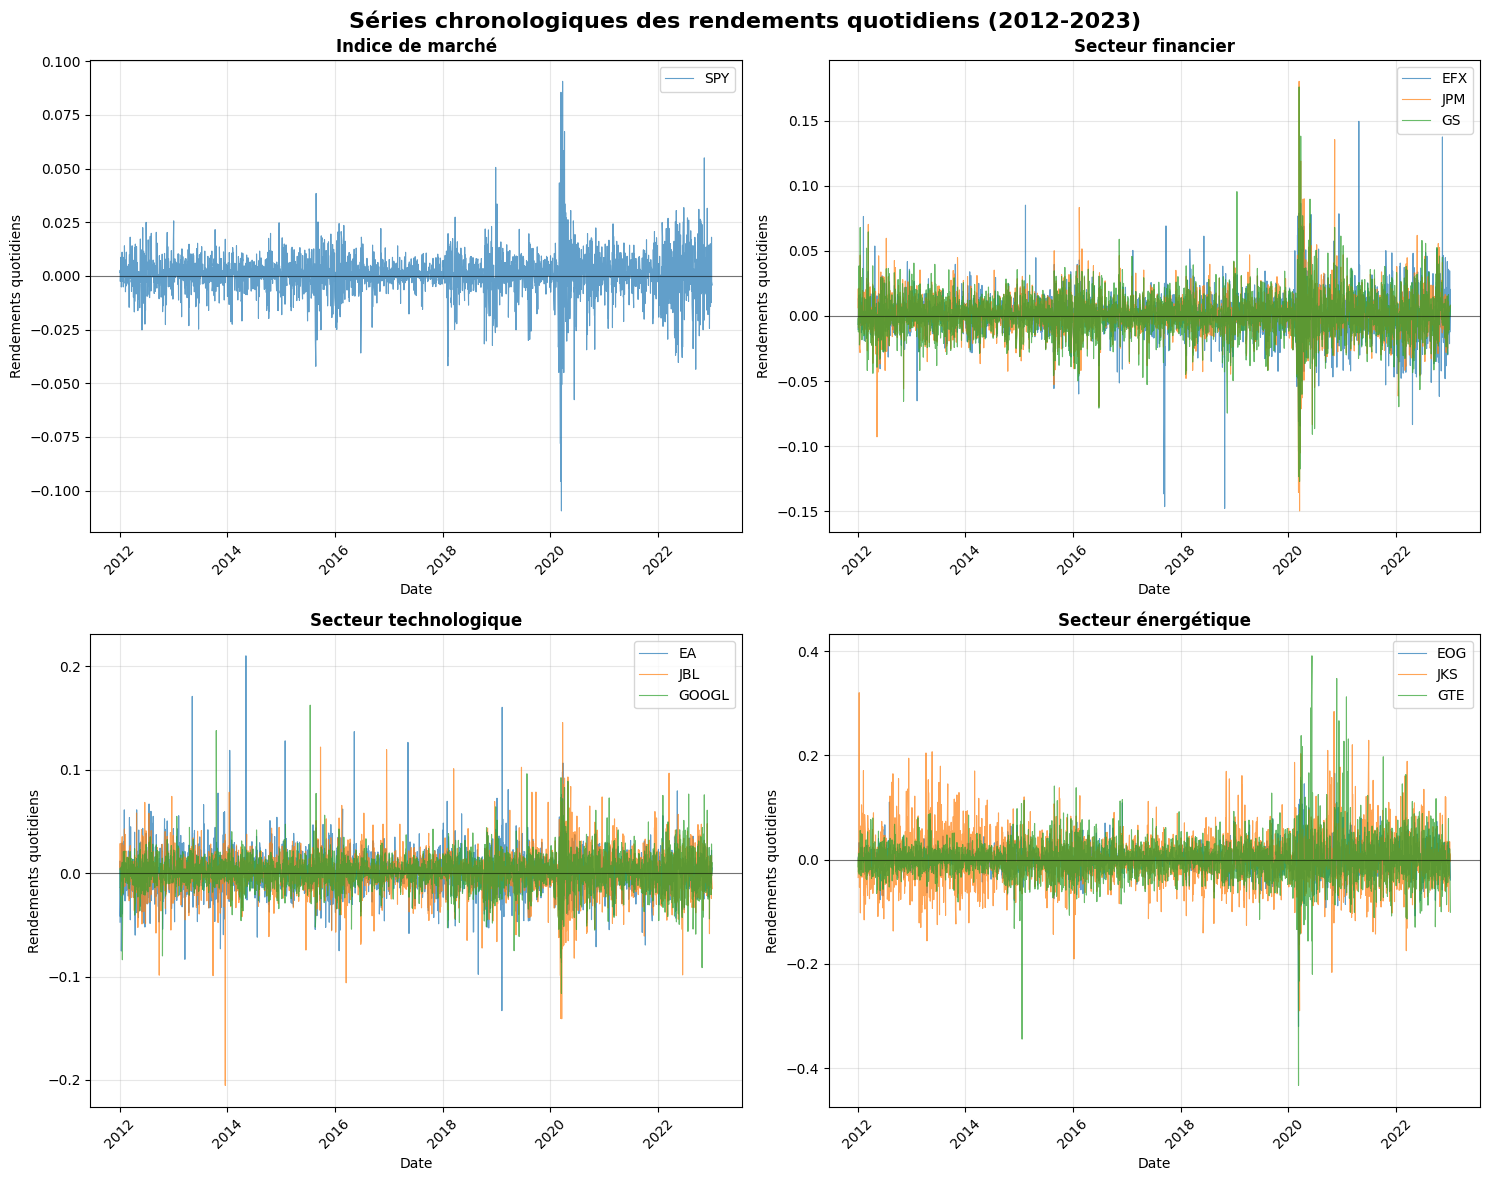

In [13]:
# GRAPHIQUES DES SÉRIES CHRONOLOGIQUES DES PRIX
print("\n=== GRAPHIQUES DES SÉRIES CHRONOLOGIQUES ===\n")

# 1. Graphique des prix ajustés
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Évolution des prix ajustés (2012-2023)', fontsize=16, fontweight='bold')

# Organiser par secteur
secteurs = ['Indice de marché', 'Secteur financier', 'Secteur technologique', 'Secteur énergétique']
colors = ['blue', 'green', 'red', 'orange']

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df[df['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['adj_close'], 
                label=ticker, linewidth=1.5, alpha=0.8)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix ajusté ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Graphique des rendements
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Séries chronologiques des rendements quotidiens (2012-2023)', fontsize=16, fontweight='bold')

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df_clean[df_clean['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['returns'], 
                label=ticker, linewidth=0.8, alpha=0.7)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rendements quotidiens')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()


=== GRAPHIQUE DES RENDEMENTS CUMULATIFS ===



C:\Users\grego\AppData\Local\Temp\ipykernel_26732\2942497207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cumulative_return'] = df_clean.groupby('ticker')['returns'].transform(lambda x: (1 + x).cumprod())


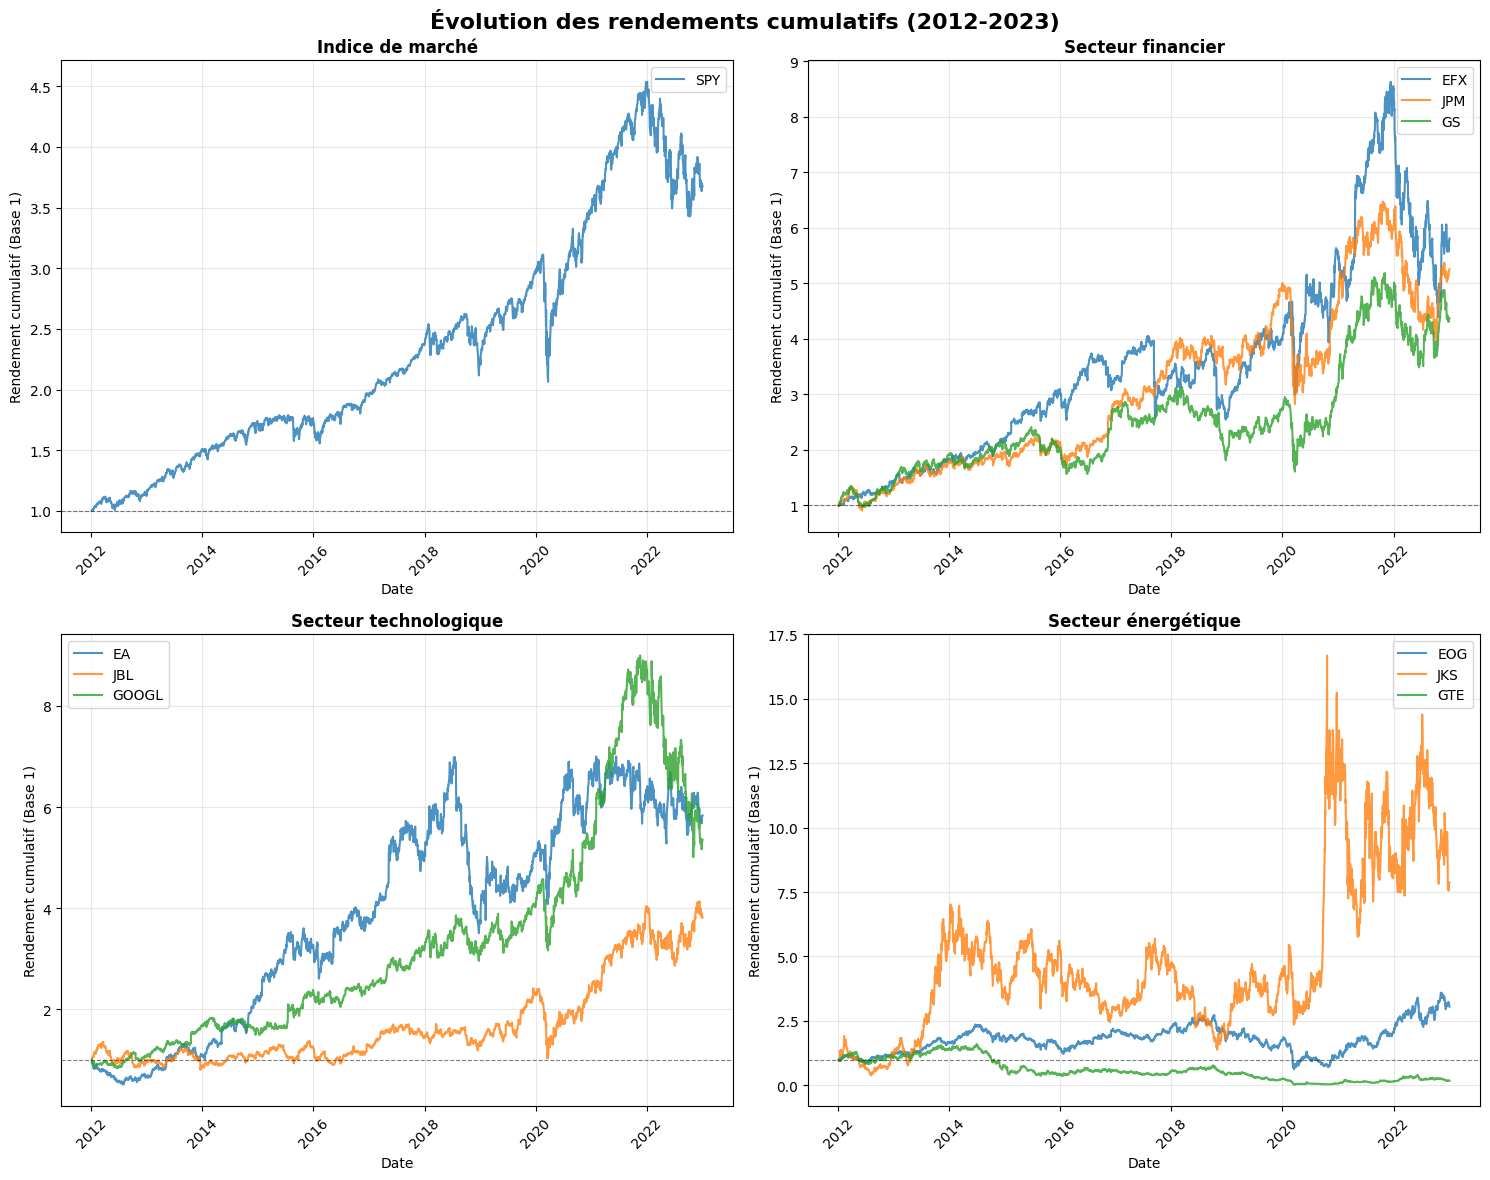

In [14]:
# GRAPHIQUE DES RENDEMENTS CUMULATIFS
print("\n=== GRAPHIQUE DES RENDEMENTS CUMULATIFS ===\n")

# Calculer les rendements cumulatifs pour chaque titre
df_clean['cumulative_return'] = df_clean.groupby('ticker')['returns'].transform(lambda x: (1 + x).cumprod())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Évolution des rendements cumulatifs (2012-2023)', fontsize=16, fontweight='bold')

secteurs = ['Indice de marché', 'Secteur financier', 'Secteur technologique', 'Secteur énergétique']

for i, secteur in enumerate(secteurs):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    tickers_secteur = [t for t in tickers_yahoo if secteurs_mapping[t] == secteur]
    
    for ticker in tickers_secteur:
        data_ticker = df_clean[df_clean['ticker'] == ticker]
        ax.plot(data_ticker['date'], data_ticker['cumulative_return'], 
                label=ticker, linewidth=1.5, alpha=0.8)
    
    ax.set_title(f'{secteur}', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rendement cumulatif (Base 1)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=0.8) # Ligne de base (pas de gain/perte)

plt.tight_layout()
plt.show()

In [15]:
# Conformément aux instructions, nous nous concentrons sur l'indice de marché, 
# une action technologique et une action énergétique.
# Nous choisissons GOOGL et EOG comme représentants de leurs secteurs.
tickers_analyse_b = ['SPY', 'GOOGL', 'EOG']
alphas = [0.05, 0.01]  # Niveaux de confiance de 5% et 1%

results = []

# Boucle sur chaque titre à analyser
for ticker in tickers_analyse_b:
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Boucle sur chaque niveau de alpha
    for alpha in alphas:
        # 1. Calcul de la VaR historique
        # C'est le quantile alpha de la distribution des rendements.
        # On prend le négatif car la VaR est exprimée en perte positive.
        var_hist = -returns.quantile(alpha)
        
        # 2. Calcul de l'ES (Expected Shortfall) historique
        # C'est la moyenne des rendements qui sont inférieurs ou égaux au quantile (c'est-à-dire pires que la VaR).
        es_hist = -returns[returns <= -var_hist].mean()
        
        results.append({
            'Ticker': ticker,
            'Secteur': secteur,
            'Niveau de confiance (alpha)': f"{(1-alpha):.0%}",
            'VaR Historique': var_hist,
            'ES Historique': es_hist
        })

# Créer un DataFrame pour présenter les résultats
results_df = pd.DataFrame(results)

print("=== VaR et ES Historiques (Non-Paramétriques) ===\n")
print(results_df.to_string(index=False))


=== VaR et ES Historiques (Non-Paramétriques) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Historique  ES Historique
   SPY      Indice de marché                         95%        0.016160       0.026223
   SPY      Indice de marché                         99%        0.030322       0.044758
 GOOGL Secteur technologique                         95%        0.025128       0.038521
 GOOGL Secteur technologique                         99%        0.046410       0.060258
   EOG   Secteur énergétique                         95%        0.035645       0.054021
   EOG   Secteur énergétique                         99%        0.062647       0.090259


In [17]:
from scipy.stats import norm

# On utilise les mêmes tickers et alphas que précédemment
results_param = []

# Boucle sur chaque titre
for ticker in tickers_analyse_b:
    returns = df_clean[df_clean['ticker'] == ticker]['returns']
    secteur = secteurs_mapping[ticker]
    
    # Calculer la moyenne et l'écart-type des rendements
    mu = returns.mean()
    sigma = returns.std()
    
    # Boucle sur chaque niveau de alpha
    for alpha in alphas:
        # 1. Calcul de la VaR paramétrique (Gaussienne)
        # VaR = - (mu + sigma * Z_alpha), où Z_alpha est le quantile de la loi normale standard
        z_score = norm.ppf(alpha)
        var_param = -(mu + sigma * z_score)
        
        # 2. Calcul de l'ES paramétrique (Gaussienne)
        # ES = - (mu - sigma * (phi(Z_alpha) / alpha)), où phi est la densité de probabilité
        es_param = -(mu - sigma * (norm.pdf(z_score) / alpha))
        
        results_param.append({
            'Ticker': ticker,
            'Secteur': secteur,
            'Niveau de confiance (alpha)': f"{(1-alpha):.0%}",
            'VaR Paramétrique': var_param,
            'ES Paramétrique': es_param
        })

# Créer un DataFrame pour les résultats paramétriques
results_param_df = pd.DataFrame(results_param)

# 1. Afficher uniquement les résultats paramétriques
print("=== VaR et ES Paramétriques (Gaussiennes) ===\n")
print(results_param_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# 2. Fusionner avec les résultats historiques pour comparaison
comparison_df = pd.merge(
    results_df,
    results_param_df,
    on=['Ticker', 'Secteur', 'Niveau de confiance (alpha)']
)
print("=== Comparaison des Modèles : Historique vs. Paramétrique (Gaussien) ===\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# 3. Calculer et afficher les deltas (écarts)
delta_df = comparison_df[['Ticker', 'Secteur', 'Niveau de confiance (alpha)']].copy()
delta_df['VaR Delta (Param - Hist)'] = comparison_df['VaR Paramétrique'] - comparison_df['VaR Historique']
delta_df['ES Delta (Param - Hist)'] = comparison_df['ES Paramétrique'] - comparison_df['ES Historique']

print("=== Delta (Écart) entre les Modèles Paramétrique et Historique ===\n")
print("Un delta positif signifie que l'estimation paramétrique est plus élevée (moins de perte ou un gain).\n")
print(delta_df.to_string(index=False))


=== VaR et ES Paramétriques (Gaussiennes) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Paramétrique  ES Paramétrique
   SPY      Indice de marché                         95%          0.017097         0.021575
   SPY      Indice de marché                         99%          0.024400         0.028031
 GOOGL Secteur technologique                         95%          0.026930         0.033961
 GOOGL Secteur technologique                         99%          0.038397         0.044099
   EOG   Secteur énergétique                         95%          0.040143         0.050523
   EOG   Secteur énergétique                         99%          0.057071         0.065489


=== Comparaison des Modèles : Historique vs. Paramétrique (Gaussien) ===

Ticker               Secteur Niveau de confiance (alpha)  VaR Historique  ES Historique  VaR Paramétrique  ES Paramétrique
   SPY      Indice de marché                         95%        0.016160       0.026223          0.017097     

=== Calcul de la VaR Récursive (EWMA) pour les niveaux 95% et 99% ===

Traitement pour SPY...
Traitement pour GOOGL...
Traitement pour EOG...

Calcul terminé. Génération des graphiques...


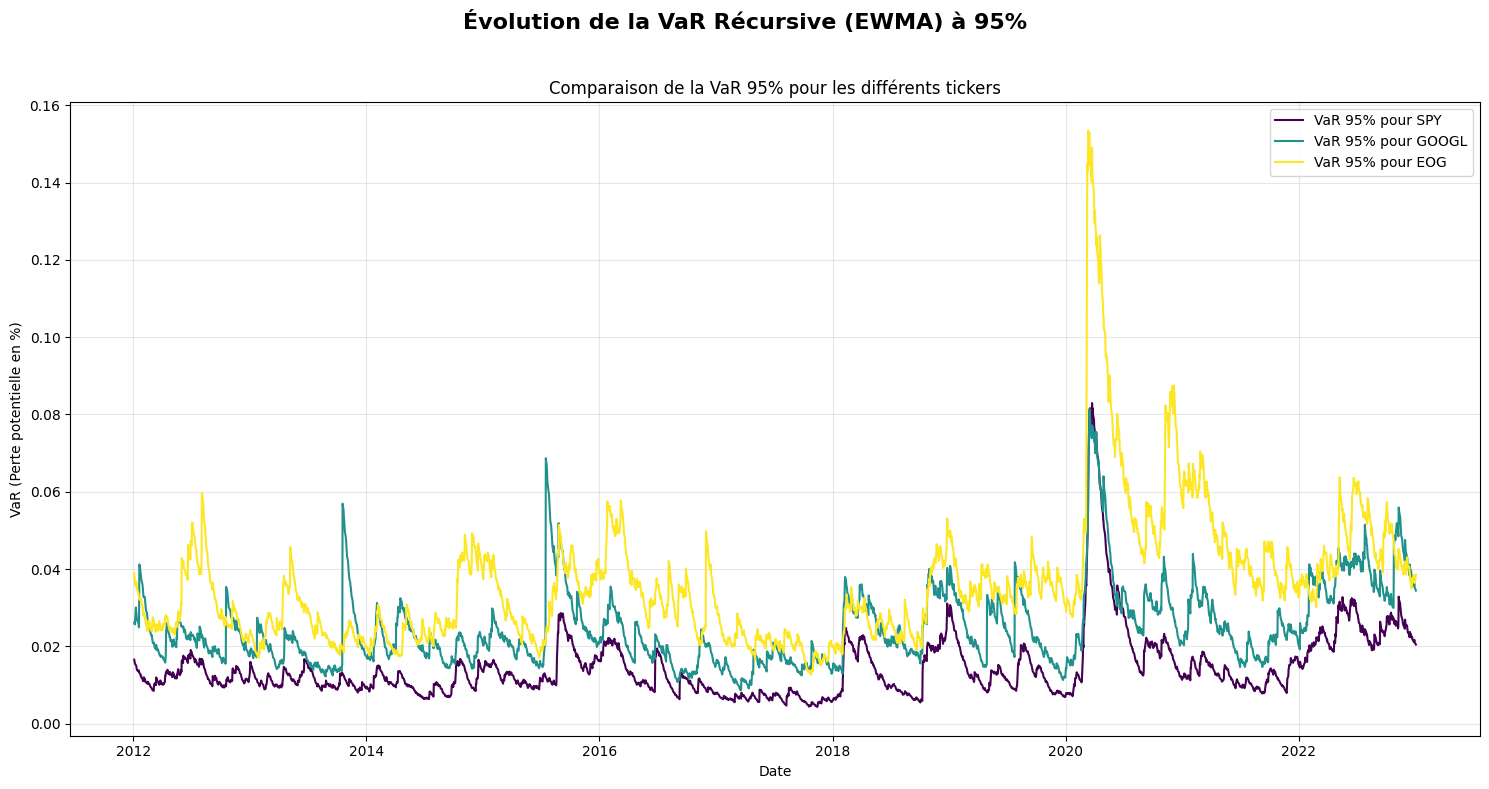

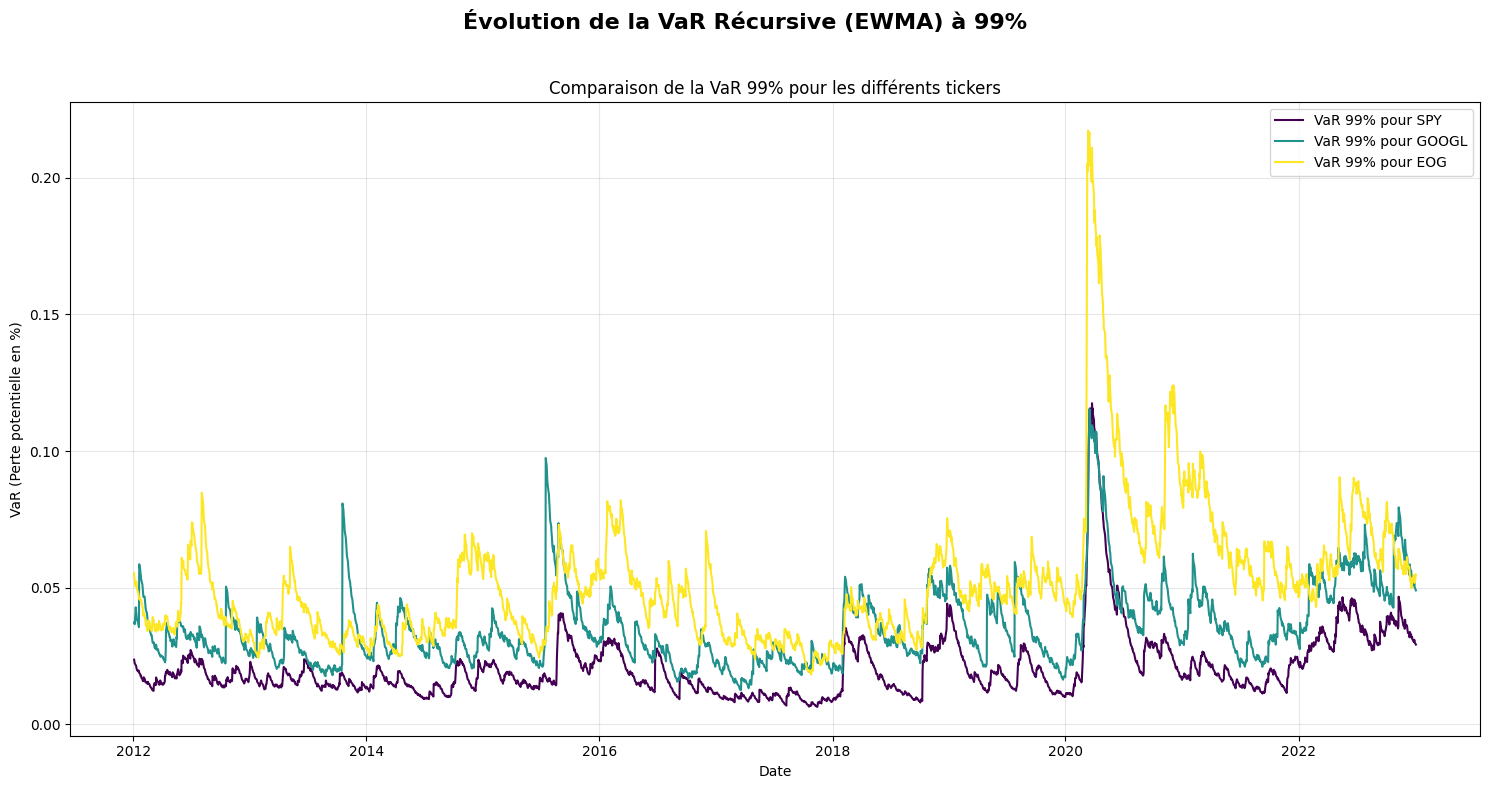

In [26]:
# --- Problème 2(d): VaR Récursive (Volatilité à pondération exponentielle) ---

# Paramètres pour le modèle EWMA (Exponentially Weighted Moving Average)
lambda_ewma = 0.94
alphas_var = {'95%': 0.05, '99%': 0.01} # Niveaux de confiance à calculer

# Préparer le DataFrame pour stocker les résultats
df_var_recursive = df_clean.copy()
df_var_recursive['ewma_vol'] = np.nan
df_var_recursive['var_recursive_95'] = np.nan
df_var_recursive['var_recursive_99'] = np.nan # Ajout pour la VaR 99%

print("=== Calcul de la VaR Récursive (EWMA) pour les niveaux 95% et 99% ===\n")

# Boucle sur chaque titre à analyser
for ticker in tickers_analyse_b:
    print(f"Traitement pour {ticker}...")
    
    # Isoler les rendements pour le ticker
    returns = df_var_recursive.loc[df_var_recursive['ticker'] == ticker, 'returns']
    
    # Initialisation de la volatilité
    vol_t_minus_1 = returns.std()
    
    # Itérer sur les rendements pour calculer la volatilité EWMA
    ewma_vol_series = []
    for r_t_minus_1 in returns:
        var_t = lambda_ewma * (vol_t_minus_1 ** 2) + (1 - lambda_ewma) * (r_t_minus_1 ** 2)
        vol_t = np.sqrt(var_t)
        ewma_vol_series.append(vol_t)
        vol_t_minus_1 = vol_t
        
    # Stocker la série de volatilité calculée
    df_var_recursive.loc[df_var_recursive['ticker'] == ticker, 'ewma_vol'] = ewma_vol_series
    
    # Calculer et stocker la VaR pour chaque niveau de confiance
    # On suppose un rendement moyen de 0 pour simplifier
    mu = returns.mean()
    for label, alpha in alphas_var.items():
        z_score = norm.ppf(alpha)
        var_recursive = -(mu + np.array(ewma_vol_series) * z_score)
        
        # Stocker la VaR dans la colonne correspondante
        col_name = f'var_recursive_{label.replace("%", "")}'
        df_var_recursive.loc[df_var_recursive['ticker'] == ticker, col_name] = var_recursive

print("\nCalcul terminé. Génération des graphiques...")

# --- Graphique 1: Évolution de la VaR Récursive (EWMA) à 95% ---
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Évolution de la VaR Récursive (EWMA) à 95%', fontsize=16, fontweight='bold')

colors = plt.cm.viridis(np.linspace(0, 1, len(tickers_analyse_b)))

for i, ticker in enumerate(tickers_analyse_b):
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    ax.plot(data_ticker['date'], data_ticker['var_recursive_95'], 
            linewidth=1.5, label=f'VaR 95% pour {ticker}', color=colors[i])

ax.set_title('Comparaison de la VaR 95% pour les différents tickers')
ax.set_ylabel('VaR (Perte potentielle en %)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Graphique 2: Évolution de la VaR Récursive (EWMA) à 99% ---
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Évolution de la VaR Récursive (EWMA) à 99%', fontsize=16, fontweight='bold')

for i, ticker in enumerate(tickers_analyse_b):
    data_ticker = df_var_recursive[df_var_recursive['ticker'] == ticker]
    ax.plot(data_ticker['date'], data_ticker['var_recursive_99'], 
            linewidth=1.5, label=f'VaR 99% pour {ticker}', color=colors[i])

ax.set_title('Comparaison de la VaR 99% pour les différents tickers')
ax.set_ylabel('VaR (Perte potentielle en %)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [27]:
# --- Problème 2(e): Stress Testing des Modèles de VaR ---

print("=== Initialisation du Stress Test ===\n")

# 1. Définir le scénario de stress
# Nous insérons une panique boursière simulée de 5 jours au début de la crise de la COVID-19
shock_date_start = '2020-03-09'
shock_returns = [-0.08, -0.10, -0.07, -0.09, -0.06] # Rendements négatifs importants
shock_duration = len(shock_returns)

# Créer une copie des données pour le stress test
df_stressed = df_clean.copy()

print(f"Injection d'un choc de {shock_duration} jours à partir du {shock_date_start}...")

# Injecter le choc pour chaque ticker analysé
for ticker in tickers_analyse_b:
    # Trouver les indices des dates à remplacer
    ticker_indices = df_stressed[df_stressed['ticker'] == ticker].index
    shock_start_date_utc = pd.to_datetime(shock_date_start).tz_localize('UTC')
    start_date_loc = df_stressed.loc[ticker_indices][df_stressed.loc[ticker_indices, 'date'] >= shock_start_date_utc].index[0]
    
    # S'assurer de ne pas dépasser la fin du DataFrame pour ce ticker
    end_loc = start_date_loc + shock_duration
    if end_loc > ticker_indices[-1]:
        # Ajuster la durée si le choc dépasse la fin des données
        shock_duration_adjusted = ticker_indices[-1] - start_date_loc + 1
        df_stressed.loc[start_date_loc:ticker_indices[-1], 'returns'] = shock_returns[:shock_duration_adjusted]
    else:
        df_stressed.loc[start_date_loc:end_loc-1, 'returns'] = shock_returns

print("Choc injecté. Recalcul des modèles de VaR sur les données stressées...\n")

# 2. Fonction pour calculer la VaR récursive pour une série
def get_recursive_var_series(returns_series, lambda_ewma=0.94, alpha=0.05):
    mu = returns_series.mean()
    z_score = norm.ppf(alpha)
    
    vol_t_minus_1 = returns_series.std()
    ewma_vol_series = []
    for r_t_minus_1 in returns_series:
        var_t = lambda_ewma * (vol_t_minus_1 ** 2) + (1 - lambda_ewma) * (r_t_minus_1 ** 2)
        vol_t = np.sqrt(var_t)
        ewma_vol_series.append(vol_t)
        vol_t_minus_1 = vol_t
        
    return -(mu + np.array(ewma_vol_series) * z_score)

# 3. Calculer les VaR avant et après le choc pour comparaison
stress_test_results = []
alphas_stress = [0.05, 0.01] # 95% et 99%

for ticker in tickers_analyse_b:
    # Isoler les données originales et stressées
    original_returns = df_clean[df_clean['ticker'] == ticker]
    stressed_returns = df_stressed[df_stressed['ticker'] == ticker]

    for alpha in alphas_stress:
        conf_level = f"{(1-alpha):.0%}"
        
        # --- VaR sur données originales ---
        var_hist_orig = -original_returns['returns'].quantile(alpha)
        var_gauss_orig = -(original_returns['returns'].mean() + original_returns['returns'].std() * norm.ppf(alpha))
        
        # Pour la récursive, on prend la valeur juste avant le choc
        col_name = f'var_recursive_{int((1-alpha)*100)}'
        var_rec_series_orig = df_var_recursive[df_var_recursive['ticker'] == ticker][col_name]
        shock_start_date_utc = pd.to_datetime(shock_date_start).tz_localize('UTC')
        loc_before_shock = original_returns[original_returns['date'] < shock_start_date_utc].index[-1]
        var_rec_before_shock = var_rec_series_orig.loc[loc_before_shock]

        # --- VaR sur données stressées ---
        var_hist_stressed = -stressed_returns['returns'].quantile(alpha)
        var_gauss_stressed = -(stressed_returns['returns'].mean() + stressed_returns['returns'].std() * norm.ppf(alpha))
        
        # Pour la récursive, on recalcule la série sur les données stressées et on prend la valeur juste après
        var_rec_series_stressed = get_recursive_var_series(stressed_returns['returns'], alpha=alpha)
        shock_end_date = pd.to_datetime(shock_date_start) + pd.Timedelta(days=shock_duration - 1)
        shock_end_date_utc = shock_end_date.tz_localize('UTC')
        loc_after_shock = stressed_returns[stressed_returns['date'] > shock_end_date_utc].index[0]
        var_rec_after_shock = var_rec_series_stressed[stressed_returns.index.get_loc(loc_after_shock)]

        # Ajouter les résultats
        stress_test_results.extend([
            {'Ticker': ticker, 'Modèle': 'Historique', 'Confiance': conf_level, 'VaR Avant Choc': var_hist_orig, 'VaR Après Choc': var_hist_stressed},
            {'Ticker': ticker, 'Modèle': 'Gaussien', 'Confiance': conf_level, 'VaR Avant Choc': var_gauss_orig, 'VaR Après Choc': var_gauss_stressed},
            {'Ticker': ticker, 'Modèle': 'Récursif (EWMA)', 'Confiance': conf_level, 'VaR Avant Choc': var_rec_before_shock, 'VaR Après Choc': var_rec_after_shock},
        ])

# 4. Créer et afficher le DataFrame de comparaison
comparison_stress_df = pd.DataFrame(stress_test_results)
comparison_stress_df['Variation (%)'] = ((comparison_stress_df['VaR Après Choc'] - comparison_stress_df['VaR Avant Choc']) / comparison_stress_df['VaR Avant Choc']) * 100

print("=== Comparaison de la Réactivité des Modèles de VaR au Choc Simulé (95% et 99%) ===\n")
print(comparison_stress_df.to_string(index=False))


=== Initialisation du Stress Test ===

Injection d'un choc de 5 jours à partir du 2020-03-09...
Choc injecté. Recalcul des modèles de VaR sur les données stressées...

=== Comparaison de la Réactivité des Modèles de VaR au Choc Simulé (95% et 99%) ===

Ticker          Modèle Confiance  VaR Avant Choc  VaR Après Choc  Variation (%)
   SPY      Historique       95%        0.016160        0.016258       0.607775
   SPY        Gaussien       95%        0.017097        0.017368       1.582730
   SPY Récursif (EWMA)       95%        0.035668        0.074714     109.467335
   SPY      Historique       99%        0.030322        0.031780       4.807846
   SPY        Gaussien       99%        0.024400        0.024735       1.375475
   SPY Récursif (EWMA)       99%        0.050665        0.105841     108.901649
 GOOGL      Historique       95%        0.025128        0.025180       0.205481
 GOOGL        Gaussien       95%        0.026930        0.027222       1.085002
 GOOGL Récursif (EWMA)     